In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import warnings
warnings.filterwarnings('ignore')

import sys
import os
from typing import List, Dict, Any
# Add the parent directory to sys.path
notebook_dir = os.path.abspath('')
project_dir = os.path.dirname(notebook_dir)
sys.path.append(project_dir)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import statsmodels.api as sm


from src.data_processing import prepare_data
from src.modeling import BayesianModel

logging.basicConfig(level=logging.ERROR)
logger = logging.getLogger(__name__)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from src.data_processing import prepare_data

In [2]:
import os
import sys
from dotenv import load_dotenv
load_dotenv()

# Determine environment and data path
environment = os.getenv('ENVIRONMENT', 'local')
data_path = os.getenv('LOCAL_DATA_PATH') if environment == 'local' else os.getenv('CLOUD_DATA_PATH')
processed_data_path = os.getenv('LOCAL_DATA_PATH_PROCESSED') if environment == 'local' else os.getenv('CLOUD_DATA_PATH')

# File paths
behavioral_path = os.path.join(data_path, 'connectome_behavioral.csv')
behavioral_path_processed = os.path.join(processed_data_path, 'connectome_behavioral.csv')


hcp_path = os.path.join(data_path, 'hcp_freesurfer.csv')
hcp_path_processed = os.path.join(processed_data_path, 'hcp_freesurfer.csv')

In [3]:
behavioral_features = [
    'Subject', 'Age', 'Gender', 'CogFluidComp_Unadj', 'CogCrystalComp_Unadj', 'MMSE_Score',
    'NEOFAC_O', 'NEOFAC_C', 'ProcSpeed_Unadj', 'CardSort_Unadj', 'PicVocab_Unadj', 'ReadEng_Unadj'
]

hcp_features = [
    'Subject', 'FS_TotCort_GM_Vol', 'FS_SubCort_GM_Vol', 'FS_Total_GM_Vol', 'FS_Tot_WM_Vol', 'FS_BrainStem_Vol',
    'FS_L_Hippo_Vol', 'FS_R_Hippo_Vol', 'FS_L_Amygdala_Vol', 'FS_R_Amygdala_Vol',
    'FS_L_Caudate_Vol', 'FS_R_Caudate_Vol', 'FS_L_Putamen_Vol', 'FS_R_Putamen_Vol',
]

categorical_columns = ['Age', 'Gender']

prior_edges = [
    ('Age', 'CogFluidComp_Unadj'),
    ('Age', 'CogCrystalComp_Unadj'),
    ('Age', 'MMSE_Score'),
    ('Gender', 'CogFluidComp_Unadj'),
    ('Gender', 'CogCrystalComp_Unadj'),
    ('MMSE_Score', 'CogFluidComp_Unadj'),
    ('MMSE_Score', 'CogCrystalComp_Unadj'),
    ('FS_Total_GM_Vol', 'CogFluidComp_Unadj'),
    ('FS_Total_GM_Vol', 'CogCrystalComp_Unadj'),
    ('FS_Tot_WM_Vol', 'CogFluidComp_Unadj'),
    ('FS_Tot_WM_Vol', 'CogCrystalComp_Unadj'),
    ('FS_L_Hippo_Vol', 'CogFluidComp_Unadj'),
    ('FS_R_Hippo_Vol', 'CogFluidComp_Unadj'),
    ('FS_L_Amygdala_Vol', 'NEOFAC_O'),
    ('FS_R_Amygdala_Vol', 'NEOFAC_O'),
    ('NEOFAC_O', 'CogCrystalComp_Unadj'),
    ('NEOFAC_C', 'CogFluidComp_Unadj'),
    ('FS_L_Hippo_Vol', 'NEOFAC_O'),
    ('FS_R_Hippo_Vol', 'NEOFAC_O'),
    ('ProcSpeed_Unadj', 'CogFluidComp_Unadj'),
    ('CardSort_Unadj', 'CogFluidComp_Unadj'),
    ('ProcSpeed_Unadj', 'CogCrystalComp_Unadj'),
    ('CardSort_Unadj', 'CogCrystalComp_Unadj'),
    ('ProcSpeed_Unadj', 'MMSE_Score'),
    ('CardSort_Unadj', 'MMSE_Score'),
    ('ProcSpeed_Unadj', 'NEOFAC_O'),
    ('CardSort_Unadj', 'NEOFAC_C'),
]

In [ ]:
# Remove these features from your feature lists
features_to_remove = ['FS_Total_GM_Vol', 'FS_TotCort_GM_Vol', 'CogCrystalComp_Unadj']

behavioral_features = [f for f in behavioral_features if f not in features_to_remove]
hcp_features = [f for f in hcp_features if f not in features_to_remove]

# Remove edges containing these features
prior_edges = [edge for edge in prior_edges if edge[0] not in features_to_remove and edge[1] not in features_to_remove]

In [4]:
def map_age_to_category(age_str):
    # Define age bins and corresponding ordinal categories
    bins = ['22-25', '26-30', '31-35', '36+']
    categories = [1, 2, 3, 4]  # Assigning ordinal values to age ranges
    
    if pd.isna(age_str):
        return np.nan
    age_str = age_str.strip()
    
    if age_str in bins:
        return categories[bins.index(age_str)]
    else:
        return np.nan

def process_age_gender(data: pd.DataFrame) -> pd.DataFrame:
    if 'Age' in data.columns and data['Age'].dtype == 'object':
        data['Age'] = data['Age'].apply(map_age_to_category)
    return data

# Load your data
behavioral_data = pd.read_csv(behavioral_path)
hcp_data = pd.read_csv(hcp_path)
# Process Age column
behavioral_data = process_age_gender(behavioral_data)

# You can now save the processed data back to CSV if needed or pass it directly to prepare_data
behavioral_data.to_csv('/Users/macbookair/Documents/NeuroBayesianModel/data/processed/connectome_behavioral.csv', index=False)

In [5]:
# Now call prepare_data
data, categorical_columns, categories = prepare_data(
    behavioral_path=behavioral_path_processed,
    hcp_path=hcp_path_processed,
    behavioral_features=behavioral_features,
    hcp_features=hcp_features,
    categorical_columns=categorical_columns,
    index='Subject'
)

model = BayesianModel(method='nsl', max_parents=6, iterations=1000, categorical_columns=categorical_columns)

# Fit the model
model.fit(data, prior_edges=prior_edges)

Created 24 nodes in total
Fitted CategoricalNode Age
Fitted CategoricalNode Gender
Initialized Inference with 24 nodes


In [6]:
if data['Age'].dtype == 'int8' or data['Gender'].dtype == 'int8':
    print("changing types")
    data['Age'] = data['Age'].astype('category')
    data['Gender'] = data['Gender'].astype('category')

changing types


In [7]:
print("\nFitting a categorical node (Age):")
age_node = model.network.nodes.get('Age')
if age_node:
    age_data = data['Age']
    age_node.fit(age_data)
    print("Age node distribution:", age_node.distribution)
else:
    print("Age node not found")

print("\nFitting a continuous node (CogFluidComp_Unadj):")
cog_fluid_node = model.network.nodes.get('CogFluidComp_Unadj')
if cog_fluid_node:
    cog_fluid_data = data['CogFluidComp_Unadj']
    parent_names = model.network.get_parents('CogFluidComp_Unadj')
    parent_data = data[parent_names] if parent_names else None
    cog_fluid_node.fit(cog_fluid_data, parent_data)
    print("CogFluidComp_Unadj node distribution:", cog_fluid_node.distribution)
else:
    print("CogFluidComp_Unadj node not found")

print("\nTrying to compute sensitivity:")
try:
    sensitivity = model.network.inference.compute_sensitivity("CogFluidComp_Unadj")
    print("Sensitivity:", sensitivity)
except Exception as e:
    print(f"Error computing sensitivity: {str(e)}")



Fitting a categorical node (Age):
Fitted CategoricalNode Age
Age node distribution: {1: 0.4366576819407008, 2: 0.344115004492363, 0: 0.20754716981132076, 3: 0.011680143755615454}

Fitting a continuous node (CogFluidComp_Unadj):
CogFluidComp_Unadj node distribution: {'intercept': 0.10189314795708238, 'beta': FS_Tot_WM_Vol     -0.061918
CardSort_Unadj     0.445977
Age               -0.033320
FS_R_Hippo_Vol    -0.028230
FS_L_Hippo_Vol     0.039102
Gender            -0.138838
FS_Total_GM_Vol    0.157863
ProcSpeed_Unadj    0.513055
MMSE_Score         0.066701
NEOFAC_C          -0.026516
dtype: float64, 'std': 0.539711654204679}

Trying to compute sensitivity:
Computing sensitivity for CogFluidComp_Unadj
Computed sensitivities for CogFluidComp_Unadj
Sensitivity: {'FS_TotCort_GM_Vol': nan, 'FS_SubCort_GM_Vol': nan, 'FS_Total_GM_Vol': nan, 'FS_Tot_WM_Vol': nan, 'FS_BrainStem_Vol': nan, 'FS_L_Hippo_Vol': nan, 'FS_R_Hippo_Vol': nan, 'FS_L_Amygdala_Vol': nan, 'FS_R_Amygdala_Vol': nan, 'FS_L_Caud

In [8]:
# Check Age and Gender distributions
print("Age distribution:")
print(data['Age'].value_counts(normalize=True))
print("\nGender distribution:")
print(data['Gender'].value_counts(normalize=True))

# Check connections
print("\nConnections to Age:")
print([edge for edge in model.network.edges if 'Age' in edge])
print("\nConnections to Gender:")
print([edge for edge in model.network.edges if 'Gender' in edge])

# Investigate Age and Gender node properties
age_node = model.network.nodes.get('Age')
gender_node = model.network.nodes.get('Gender')

if age_node:
    print("\nAge node properties:")
    print(f"Distribution: {age_node.distribution}")
else:
    print("\nAge node not found in the network")

if gender_node:
    print("\nGender node properties:")
    print(f"Distribution: {gender_node.distribution}")
else:
    print("\nGender node not found in the network")

Age distribution:
Age
1    0.436658
2    0.344115
0    0.207547
3    0.011680
Name: proportion, dtype: float64

Gender distribution:
Gender
0    0.544474
1    0.455526
Name: proportion, dtype: float64

Connections to Age:
[('Age', 'CogCrystalComp_Unadj'), ('Age', 'MMSE_Score'), ('Age', 'CogFluidComp_Unadj'), ('Age', 'FS_Tot_WM_Vol'), ('FS_Tot_WM_Vol', 'Age'), ('FS_R_Hippo_Vol', 'Age'), ('FS_SubCort_GM_Vol', 'Age'), ('Age', 'PicVocab_Unadj'), ('CogFluidComp_Unadj', 'Age'), ('PicVocab_Unadj', 'Age'), ('FS_Total_GM_Vol', 'Age')]

Connections to Gender:
[('Gender', 'FS_TotCort_GM_Vol'), ('Gender', 'PicVocab_Unadj'), ('FS_L_Amygdala_Vol', 'Gender'), ('Gender', 'CardSort_Unadj'), ('FS_TotCort_GM_Vol', 'Gender'), ('FS_L_Caudate_Vol', 'Gender'), ('FS_Total_GM_Vol', 'Gender'), ('Gender', 'FS_L_Caudate_Vol'), ('Gender', 'NEOFAC_C'), ('Gender', 'CogCrystalComp_Unadj'), ('Gender', 'MMSE_Score'), ('FS_R_Putamen_Vol', 'Gender'), ('Gender', 'CogFluidComp_Unadj'), ('Gender', 'FS_Total_GM_Vol'), ('MMSE

In [9]:
# Check parameters for a continuous node (e.g., CogFluidComp_Unadj)
cog_fluid_node = model.network.nodes.get('CogFluidComp_Unadj')
if cog_fluid_node:
    print("\nCogFluidComp_Unadj node properties:")
    print(f"Distribution: {cog_fluid_node.distribution}")
    print(f"Parents: {[parent.name for parent in cog_fluid_node.parents]}")

# Check the fit method for categorical and continuous nodes
print("\nFitting Age node (categorical):")
age_data = data['Age']
model.network.nodes['Age'].fit(age_data)

print("\nFitting CogFluidComp_Unadj node (continuous):")
cog_fluid_data = data['CogFluidComp_Unadj']
parent_data = data[[parent.name for parent in cog_fluid_node.parents]] if cog_fluid_node.parents else None
model.network.nodes['CogFluidComp_Unadj'].fit(cog_fluid_data, parent_data)

# Check sensitivity computation
print("\nComputing sensitivity for CogFluidComp_Unadj:")
try:
    sensitivity = model.network.inference.compute_sensitivity("CogFluidComp_Unadj")
    print(sensitivity)
except Exception as e:
    print(f"Error computing sensitivity: {str(e)}")


CogFluidComp_Unadj node properties:
Distribution: {'intercept': 0.10189314795708238, 'beta': FS_Tot_WM_Vol     -0.061918
CardSort_Unadj     0.445977
Age               -0.033320
FS_R_Hippo_Vol    -0.028230
FS_L_Hippo_Vol     0.039102
Gender            -0.138838
FS_Total_GM_Vol    0.157863
ProcSpeed_Unadj    0.513055
MMSE_Score         0.066701
NEOFAC_C          -0.026516
dtype: float64, 'std': 0.539711654204679}
Parents: ['FS_Tot_WM_Vol', 'CardSort_Unadj', 'Age', 'FS_R_Hippo_Vol', 'FS_L_Hippo_Vol', 'Gender', 'FS_Total_GM_Vol', 'ProcSpeed_Unadj', 'MMSE_Score', 'NEOFAC_C']

Fitting Age node (categorical):
Fitted CategoricalNode Age

Fitting CogFluidComp_Unadj node (continuous):

Computing sensitivity for CogFluidComp_Unadj:
Computing sensitivity for CogFluidComp_Unadj
Computed sensitivities for CogFluidComp_Unadj
{'FS_TotCort_GM_Vol': nan, 'FS_SubCort_GM_Vol': nan, 'FS_Total_GM_Vol': nan, 'FS_Tot_WM_Vol': nan, 'FS_BrainStem_Vol': nan, 'FS_L_Hippo_Vol': nan, 'FS_R_Hippo_Vol': nan, 'FS_L_A

In [10]:

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X = data.drop(['CogFluidComp_Unadj'], axis=1)
y = data['CogFluidComp_Unadj']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)

print("Linear Regression R2 score:", lr.score(X_test, y_test))
print("\nFeature importances:")
for feature, importance in zip(X.columns, lr.coef_):
    print(f"{feature}: {importance}")

Linear Regression R2 score: 0.6999244499360504

Feature importances:
FS_TotCort_GM_Vol: 0.08929133994977521
FS_SubCort_GM_Vol: 0.12132089121912362
FS_Total_GM_Vol: 0.03019141196166035
FS_Tot_WM_Vol: 0.010009030022535607
FS_BrainStem_Vol: -0.06530299029624428
FS_L_Hippo_Vol: -0.009467560127908337
FS_R_Hippo_Vol: -0.008268867183174114
FS_L_Amygdala_Vol: -0.020334466595473256
FS_R_Amygdala_Vol: -0.01702475774659508
FS_L_Caudate_Vol: 0.02312038292431573
FS_R_Caudate_Vol: -0.05655238036509647
FS_L_Putamen_Vol: -0.10480421385470326
FS_R_Putamen_Vol: -0.0021368852801098084
Age: -0.07123145026254457
Gender: -0.13086763986494776
CogCrystalComp_Unadj: 0.1925521100523942
MMSE_Score: 0.015413221885538047
NEOFAC_O: 0.006833232152044816
NEOFAC_C: -0.007073107166799539
ProcSpeed_Unadj: 0.5065257245048078
CardSort_Unadj: 0.43528967302155264
PicVocab_Unadj: 0.014361633799597866
ReadEng_Unadj: -0.04882335293581423


In [11]:
from scipy.stats import skew

def detect_skewed_variables(data, threshold=1.0):
    skewed_vars = {}
    for column in data.select_dtypes(include=[np.number]).columns:
        skewness = skew(data[column].dropna())
        if abs(skewness) > threshold:
            skewed_vars[column] = skewness
    return skewed_vars

# Use the function
skewed_variables = detect_skewed_variables(data)
print("Skewed variables:")
for var, skewness in skewed_variables.items():
    print(f"{var}: {skewness}")

# Apply log transformation to skewed variables
for var in skewed_variables.keys():
    data[f"{var}_log"] = np.log1p(data[var])

data['MMSE_Score_log'] = np.log1p(data['MMSE_Score'])
print("Skewness after log transform:", data['MMSE_Score_log'].skew())

Skewed variables:
FS_R_Amygdala_Vol: -3.7681691830105803
MMSE_Score: -2.577900907837692
Skewness after log transform: -1.3513276320728649


         Age  Gender
count   1113    1113
unique     4       2
top        1       0
freq     486     606


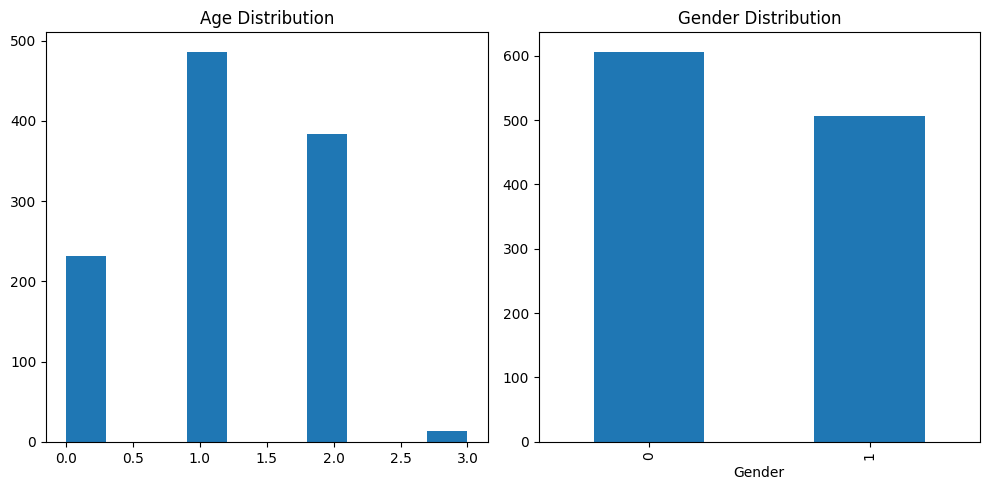

Correlations with CogFluidComp_Unadj:
Age                  -0.156006
Gender                0.063540
CogFluidComp_Unadj    1.000000
Name: CogFluidComp_Unadj, dtype: float64


In [12]:
print(data[['Age', 'Gender']].describe())

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.hist(data['Age'])
plt.title('Age Distribution')
plt.subplot(122)
data['Gender'].value_counts().plot(kind='bar')
plt.title('Gender Distribution')
plt.tight_layout()
plt.show()

print("Correlations with CogFluidComp_Unadj:")
print(data[['Age', 'Gender', 'CogFluidComp_Unadj']].corr()['CogFluidComp_Unadj'])

In [13]:
print("Parents of CogFluidComp_Unadj:", model.network.get_parents('CogFluidComp_Unadj'))

Parents of CogFluidComp_Unadj: ['FS_Tot_WM_Vol', 'CardSort_Unadj', 'Age', 'FS_R_Hippo_Vol', 'FS_L_Hippo_Vol', 'Gender', 'FS_Total_GM_Vol', 'ProcSpeed_Unadj', 'MMSE_Score', 'NEOFAC_C']


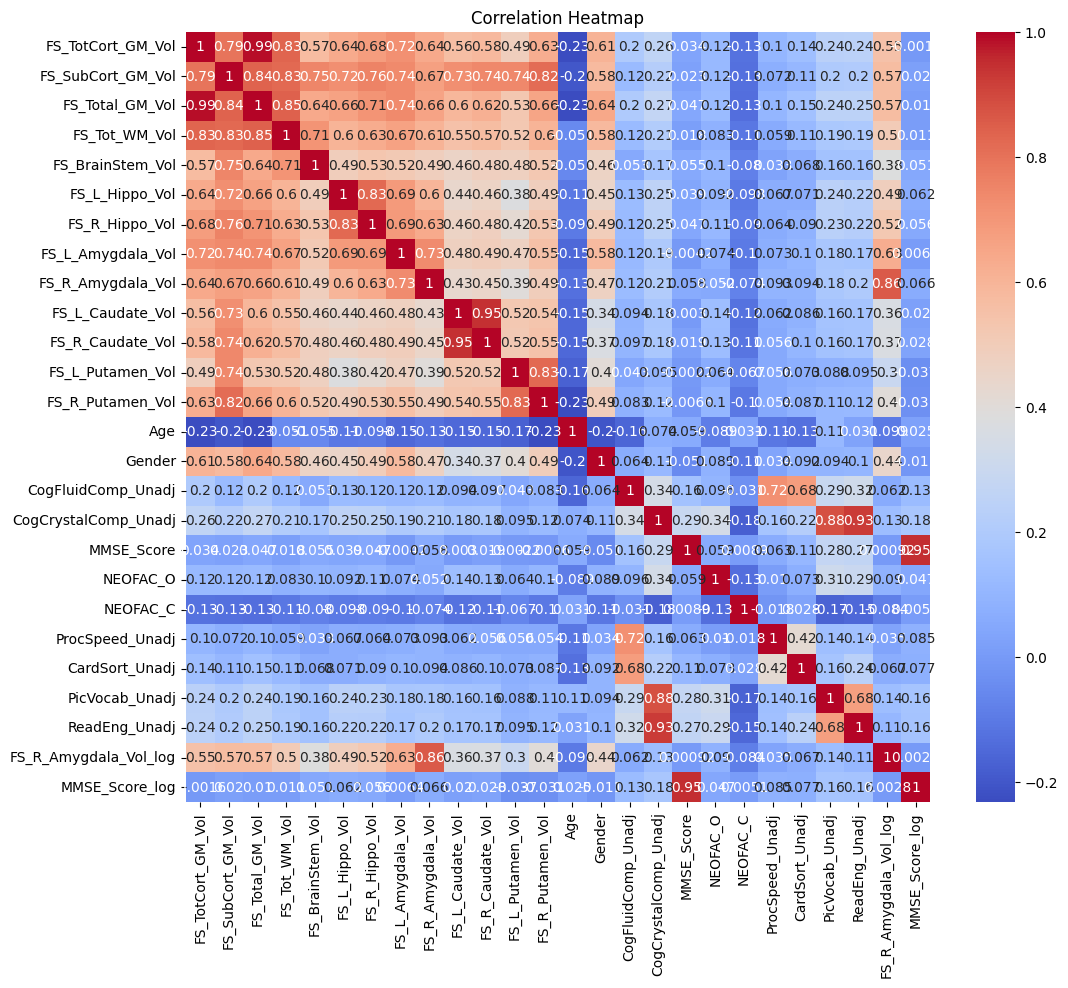

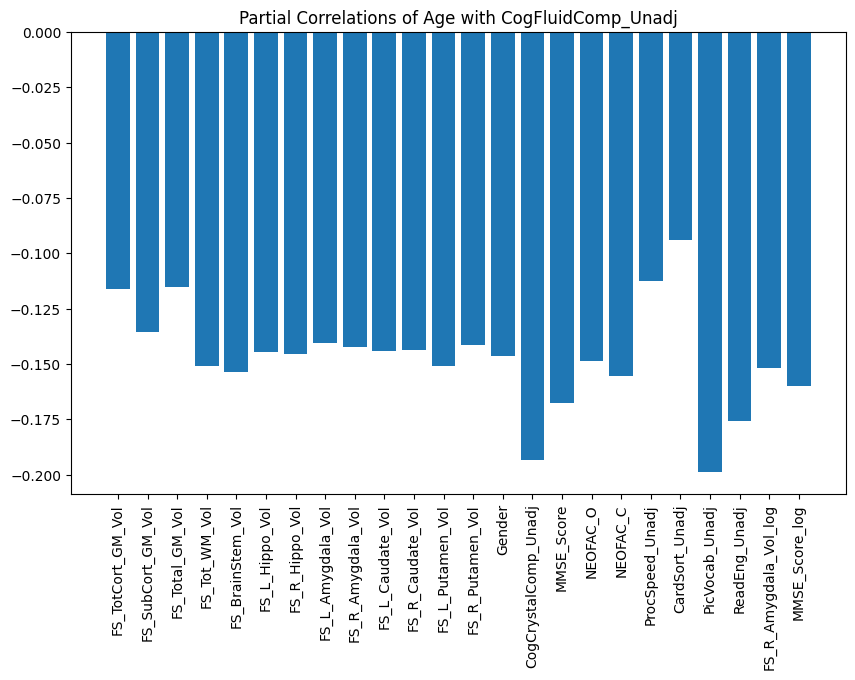

In [14]:
# Correlation heatmap
corr = data.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Partial correlation
from scipy.stats import pearsonr
def partial_corr(x, y, z):
    xy, _ = pearsonr(x, y)
    xz, _ = pearsonr(x, z)
    yz, _ = pearsonr(y, z)
    return (xy - xz * yz) / (np.sqrt(1 - xz**2) * np.sqrt(1 - yz**2))

age_partial_corrs = {}
for col in data.columns:
    if col != 'Age' and col != 'CogFluidComp_Unadj':
        age_partial_corrs[col] = partial_corr(data['Age'].fillna(0), data['CogFluidComp_Unadj'].fillna(0), data[col].fillna(0))

plt.figure(figsize=(10,6))
plt.bar(age_partial_corrs.keys(), age_partial_corrs.values())
plt.xticks(rotation=90)
plt.title('Partial Correlations of Age with CogFluidComp_Unadj')
plt.show()

In [15]:
import pandas as pd
import numpy as np
from scipy import stats

# Assuming processed_data is your preprocessed DataFrame

def partial_correlation(x, y, z):
    xy_corr = stats.pearsonr(x, y)[0]
    xz_corr = stats.pearsonr(x, z)[0]
    yz_corr = stats.pearsonr(y, z)[0]
    return (xy_corr - xz_corr * yz_corr) / np.sqrt((1 - xz_corr**2) * (1 - yz_corr**2))

age_effects = {}
for column in data.columns:
    if column not in ['Age', 'CogFluidComp_Unadj']:
        direct_corr = stats.pearsonr(data['Age'], data['CogFluidComp_Unadj'])[0]
        partial_corr = partial_correlation(data['Age'].fillna(0), data['CogFluidComp_Unadj'].fillna(0), data[column].fillna(0))
        age_effects[column] = {
            'direct_correlation': direct_corr,
            'partial_correlation': partial_corr,
            'difference': direct_corr - partial_corr
        }

# Sort by the difference to see which variables capture the most age effects
sorted_age_effects = sorted(age_effects.items(), key=lambda x: abs(x[1]['difference']), reverse=True)

for column, effects in sorted_age_effects[:10]:  # Show top 10
    print(f"{column}:")
    print(f"  Direct correlation: {effects['direct_correlation']:.4f}")
    print(f"  Partial correlation: {effects['partial_correlation']:.4f}")
    print(f"  Difference: {effects['difference']:.4f}")
    print()

CardSort_Unadj:
  Direct correlation: -0.1560
  Partial correlation: -0.0941
  Difference: -0.0619

ProcSpeed_Unadj:
  Direct correlation: -0.1560
  Partial correlation: -0.1126
  Difference: -0.0434

PicVocab_Unadj:
  Direct correlation: -0.1560
  Partial correlation: -0.1987
  Difference: 0.0427

FS_Total_GM_Vol:
  Direct correlation: -0.1560
  Partial correlation: -0.1153
  Difference: -0.0407

FS_TotCort_GM_Vol:
  Direct correlation: -0.1560
  Partial correlation: -0.1163
  Difference: -0.0398

CogCrystalComp_Unadj:
  Direct correlation: -0.1560
  Partial correlation: -0.1935
  Difference: 0.0375

FS_SubCort_GM_Vol:
  Direct correlation: -0.1560
  Partial correlation: -0.1353
  Difference: -0.0207

ReadEng_Unadj:
  Direct correlation: -0.1560
  Partial correlation: -0.1755
  Difference: 0.0195

FS_L_Amygdala_Vol:
  Direct correlation: -0.1560
  Partial correlation: -0.1405
  Difference: -0.0155

FS_R_Putamen_Vol:
  Direct correlation: -0.1560
  Partial correlation: -0.1414
  Differ

In [16]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def check_multicollinearity(data):
    vif_data = pd.DataFrame()
    vif_data["feature"] = data.columns
    vif_data["VIF"] = [variance_inflation_factor(data.fillna(0).values, i) for i in range(len(data.columns))]
    return vif_data.sort_values('VIF', ascending=False)

vif_results = check_multicollinearity(data)
print("Multicollinearity check (VIF):")
print(vif_results)
print("\nVariables with VIF > 5 might be problematic.")

# Check for outliers
def check_outliers(data):
    outliers = {}
    for column in data.select_dtypes(include=[np.number]).columns:
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[column] = ((data[column] < lower_bound) | (data[column] > upper_bound)).sum()
    return outliers

outlier_counts = check_outliers(data)
print("\nOutlier counts:")
for column, count in outlier_counts.items():
    if count > 0:
        print(f"{column}: {count}")

# Check for missing values (if any left after preprocessing)
missing_values = data.isnull().sum()
if missing_values.sum() > 0:
    print("\nMissing values:")
    print(missing_values[missing_values > 0])
else:
    print("\nNo missing values found.")

# Check distribution of target variable
from scipy import stats

target_skewness = stats.skew(data['CogFluidComp_Unadj'])
target_kurtosis = stats.kurtosis(data['CogFluidComp_Unadj'])

print(f"\nTarget variable (CogFluidComp_Unadj) distribution:")
print(f"Skewness: {target_skewness:.4f}")
print(f"Kurtosis: {target_kurtosis:.4f}")
print("Note: For normal distribution, skewness should be close to 0 and kurtosis close to 3.")

# Basic model assumptions check (for linear relationships)
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm

X = sm.add_constant(data.drop('CogFluidComp_Unadj', axis=1).fillna(0))
y = data['CogFluidComp_Unadj'].fillna(0)
model = sm.OLS(y, X).fit()

print("\nDurbin-Watson statistic:")
print(durbin_watson(model.resid))
print("Note: Value should be close to 2 for no autocorrelation.")

print("\nBreusch-Pagan test for heteroscedasticity:")
from statsmodels.stats.diagnostic import het_breuschpagan
bp_test = het_breuschpagan(model.resid, model.model.exog)
print(f"LM statistic: {bp_test[0]:.4f}")
print(f"LM p-value: {bp_test[1]:.4f}")
print("Note: Low p-value suggests presence of heteroscedasticity.")

Multicollinearity check (VIF):
                  feature        VIF
2         FS_Total_GM_Vol  70.060061
0       FS_TotCort_GM_Vol  56.193519
16   CogCrystalComp_Unadj  44.654084
1       FS_SubCort_GM_Vol  22.710597
23          ReadEng_Unadj  18.195477
22         PicVocab_Unadj  11.681933
10       FS_R_Caudate_Vol  10.328591
9        FS_L_Caudate_Vol   9.993251
3           FS_Tot_WM_Vol   5.393380
12       FS_R_Putamen_Vol   5.183314
6          FS_R_Hippo_Vol   4.263739
11       FS_L_Putamen_Vol   3.903321
5          FS_L_Hippo_Vol   3.773490
15     CogFluidComp_Unadj   3.695135
7       FS_L_Amygdala_Vol   3.430927
4        FS_BrainStem_Vol   3.241155
8       FS_R_Amygdala_Vol   2.558589
14                 Gender   2.409477
20        ProcSpeed_Unadj   2.198274
21         CardSort_Unadj   1.982861
13                    Age   1.894130
17             MMSE_Score   1.557656
24  FS_R_Amygdala_Vol_log   1.544826
25         MMSE_Score_log   1.439574
18               NEOFAC_O   1.188137
19     